In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
# Instala dependências
!pip install imbalanced-learn

In [2]:
import matplotlib
matplotlib.use('Agg')  # Use renderizador ideal para exportar imagens

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from itertools import product
from sklearn.base import clone
from joblib import Parallel, delayed


In [55]:
# ─── Função de CV que concatena todas as predições ─────────────────────────
def run_cv_for_embedding(
    emb_path, clf, sampler, n_splits,
    X_extra, y_true, class_names,
    clf_name, bal_name, emb_folder, test
):
    if test == "only_emb":
        X = np.load(emb_path)
    elif test == "only_extra":
        X = X_extra
    else:
      emb = np.load(emb_path)
      X = np.hstack((emb, X_extra))

    X = StandardScaler().fit_transform(X)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    y_true_all = []
    y_pred_all = []
    probas_all = []

    for train_idx, test_idx in skf.split(X, y_true):
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = y_true[train_idx], y_true[test_idx]

        if sampler:
            X_tr, y_tr = sampler.fit_resample(X_tr, y_tr)

        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_te)
        try:
            y_proba = clf.predict_proba(X_te)
        except AttributeError:
            y_proba = None  # ou np.zeros_like(y_pred) se quiser manter a estrutura

        y_true_all.extend(y_te)
        y_pred_all.extend(y_pred)
        probas_all.append(y_proba)

    # ─── Gera relatório detalhado por classe ─────────────────────────────
    report = classification_report(y_true_all, y_pred_all, target_names=class_names, output_dict=True, zero_division=0)
    df_report = pd.DataFrame(report).transpose()
    report_filename = f"{clf_name}_{bal_name}_{emb_folder}_metrics.csv".replace(" ", "_")
    report_path = os.path.join(cm_png_dir, report_filename)
    df_report.to_csv(report_path, sep=';', decimal=',')

    # ─── Matriz de confusão geral ─────────────────────────────────────────
    cm = confusion_matrix(y_true_all, y_pred_all, labels=range(len(class_names)))
    cm_percent = cm.astype(float) / cm.sum(axis=1)[:, None]
    cm_percent = np.nan_to_num(cm_percent)  # Substitui NaN por 0

    # ─── Anotações com valor absoluto e percentual ────────────────
    annotations = np.array([
        [f"{abs_val}\n({perc_val:.2%})" for abs_val, perc_val in zip(row_abs, row_perc)]
        for row_abs, row_perc in zip(cm, cm_percent)
    ])

    # ─── Heatmap aprimorado ────────────────────────────────────────
    plt.figure(figsize=(10, 8), dpi=400)
    sns.set(font_scale=0.8)

    ax = sns.heatmap(
        cm_percent,
        annot=annotations,
        fmt='',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=True,
        square=True,
        linewidths=0.5,
        linecolor='gray'
    )

    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Predict', fontsize=12)
    plt.ylabel('True', fontsize=12)
    title = f"CM geral — {clf_name} | {bal_name} | {emb_folder}"
    wrapped_title = "\n".join([title[i:i+45] for i in range(0, len(title), 45)])
    plt.title(wrapped_title, fontsize=12, pad=10, loc='center')
    plt.tight_layout()

    # Salva o arquivo em alta resolução
    cm_filename = f'{clf_name}_{bal_name}_{emb_folder}_confusion_matrix.png'.replace(" ", "_")
    cm_path = os.path.join(cm_png_dir, cm_filename)
    plt.savefig(cm_path, dpi=400, bbox_inches='tight')
    plt.close()

    # ─── TP, FP, FN, TN ──────────────────────────────────────────────
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    TN = np.sum(cm) - (TP + FP + FN)

    df_confusion_metrics = pd.DataFrame({
        'Classe': class_names,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN
    })
    metrics_filename = f'{clf_name}_{bal_name}_{emb_folder}_result.csv'.replace(" ", "_")
    metrics_path = os.path.join(metrics_dir, metrics_filename)
    df_confusion_metrics.to_csv(metrics_path, sep=';', decimal=',', index=False)

    # Para exibir a soma total geral:
    TP_total = TP.sum()
    FP_total = FP.sum()
    FN_total = FN.sum()
    TN_total = TN.sum()

    #print(f'TP_total: {TP_total}, FP_total: {FP_total}, FN_total: {FN_total}, TN_total: {TN_total}')

    # ─── Métricas únicas ─────────────────────────────────────────────────
    accuracy  = accuracy_score(y_true_all, y_pred_all)
    precision = precision_score(y_true_all, y_pred_all, average='macro', zero_division=0)
    recall    = recall_score(y_true_all, y_pred_all, average='macro', zero_division=0)
    f1        = f1_score(y_true_all, y_pred_all, average='macro', zero_division=0)

    print(f'accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {f1}')

    # ─── ROC AUC one-vs-rest com visual refinado ───────────────────────────────
    
    if any(p is None for p in probas_all):
        aucs = {}  # Pula geração dos gráficos e métricas AUC
    else:
        y_bin = label_binarize(y_true_all, classes=range(len(class_names)))
        probs = np.vstack(probas_all)
        aucs = {}

        roc_subdir = os.path.join(
            roc_png_dir,
            f"{clf_name}_{bal_name}_{emb_folder}".replace(" ", "_")
        )
        os.makedirs(roc_subdir, exist_ok=True)

        for i, cls in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
            aucs[cls] = auc(fpr, tpr)

            # Figura com dimensões apropriadas para artigo
            plt.figure(figsize=(4, 3), dpi=400)
            plt.plot(fpr, tpr, label=f"AUC = {aucs[cls]:.2f}", lw=1.5)
            plt.plot([0, 1], [0, 1], 'k--', lw=0.7)

            # Eixos
            plt.xlabel('FPR (Taxa de Falsos Positivos)', fontsize=9)
            plt.ylabel('TPR (Taxa de Verdadeiros Positivos)', fontsize=9)
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)

            # Título centralizado com quebra automática se for longo
            title_str = f"ROC {cls} — {clf_name}"
            title_wrapped = "\n".join([title_str[i:i+40] for i in range(0, len(title_str), 40)])
            plt.title(title_wrapped, fontsize=10, pad=10, loc='center')

            # Legenda com margem
            plt.legend(loc='lower right', fontsize=8)

            roc_filename = f"{cls}.png".replace(" ", "_")
            roc_path = os.path.join(roc_subdir, roc_filename)

            # Salvar a figura em alta resolução
            plt.tight_layout()
            plt.savefig(roc_path, dpi=400, bbox_inches='tight')
            plt.close()


    return {
        'accuracy':       accuracy,
        'precision_macro':precision,
        'recall_macro':   recall,
        'f1_macro':       f1,
        'tp':             TP_total,
        'tn':             TN_total,
        'fp':             FP_total,
        'fn':             FN_total,
        'roc_auc':        aucs,
        'cm_path':        cm_path
    },{
        'y_true': y_true_all,
        'y_pred': y_pred_all
    }

# ─── Configurações ─────────────────────────────────────────────
results = []
n_splits = 10
#test='only_emb'
#test='only_extra'
test='emb_extra'

#embeddings_parent_dir = '/content/drive/MyDrive/ethereum/Embeddings/results_dynamic_7categorys/'
embeddings_parent_dir = 'C:/Users/samue/Downloads/NFT25/results_dynamic_7categorys/'
embeddings_parent_dir = 'C:/Users/samue/Downloads/NFT25/results_dynamic_7categorys_set/'
#dataset_csv_path      = '/content/drive/MyDrive/ethereum/dataframe/dataset_v2_atributos.csv'
dataset_csv_path      = 'C:/Users/samue/Downloads/dataset_v2_atributos_25.csv'
#base_path = f'/content/drive/MyDrive/testes_ethereum/{test}/'  # Diretório base para todos os testes
base_path = f'C:/Users/samue/Downloads/NFT25/final_novo_set/{test}/'  # Diretório base para todos os testes
cm_png_dir            = f'{base_path}confusion_matrices/'
roc_png_dir           = f'{base_path}roc_curves/'
metrics_dir           = f'{base_path}metrics/'
predict_dir           = f'{base_path}predictions/'

directories = [embeddings_parent_dir, cm_png_dir, roc_png_dir, metrics_dir, predict_dir]

for dir_path in directories:
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)

# ─── Carrega o CSV de atributos + categoria ─────────────────────────────────
data = pd.read_csv(dataset_csv_path, header=0, sep=';')

data['category'] = data['category'].str.replace('_', '-')
data = data[data['category'].notnull()].reset_index(drop=True)
data = data[data['slug'] != 'panoramic-portraits'].reset_index(drop=True)

data = data[~data['category'].isin(['domain-names', 'sports-collectibles'])].reset_index(drop=True)

#############
# Filtrar data2 para manter apenas as linhas cujas 'slug' estão presentes em data

data2 = pd.read_csv("C:/Users/samue/Downloads/dataset_description.csv")
data2 = data2[~data2['category'].isin(['domain-names', 'sports-collectibles'])]
data2 = data2[data2['slug'] != 'panoramic-portraits'].reset_index(drop=True)
slugs_data = set(data2['slug'])

data_filtrado = data[data['slug'].isin(slugs_data)].reset_index(drop=True)
data = data_filtrado.copy()

#############
unique_classes = data['category'].unique()

# ─── Prepara features e rótulos ─────────────────────────────────────────────
numeric_cols = [
    'total_volume','total_sales','total_supply',
    'num_owners','average_price','market_cap',
    'qtd_traits','qtd_editors'
]
y = data['category'].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)
extra_features = data[numeric_cols].values
class_names = le.classes_

# ─── Classificadores e balanceadores ───────────────────────────────────────
classifiers = {
    'kNN':               KNeighborsClassifier(),
    'SVM':                SVC(probability=True, random_state=42),
    'DTree':      DecisionTreeClassifier(random_state=42),
    'RF':      RandomForestClassifier(random_state=42),
    'LogReg': LogisticRegression(max_iter=200, random_state=42)
}
balancing_methods = {
    'unbalanced': None,
    'undersampling':     RandomUnderSampler(random_state=42),
    'oversampling':      RandomOverSampler(random_state=42),
    'smote':             SMOTE(random_state=42)
}

# ─── VotingClassifiers (hard e soft) ───────────────────────────────────────
voting_hard = VotingClassifier(
    estimators=[
        ('kNN', classifiers['kNN']),
        ('SVM', classifiers['SVM']),
        ('DTree', classifiers['DTree']),
        ('RF', classifiers['RF']),
        ('LogReg', classifiers['LogReg'])
    ],
    voting='hard'
)

voting_soft = VotingClassifier(
    estimators=[
        ('kNN', classifiers['kNN']),
        ('SVM', classifiers['SVM']),
        ('DTree', classifiers['DTree']),
        ('RF', classifiers['RF']),
        ('LogReg', classifiers['LogReg'])
    ],
    voting='soft'
)

classifiers['VotingHard'] = voting_hard
classifiers['VotingSoft'] = voting_soft

progress_tot = len(embeddings_parent_dir)*len(classifiers)*len(balancing_methods)
progress_cont = 0
# ─── Execução principal ─────────────────────────────────────────────────────
'''
only_dirs = [
    item for item in os.listdir(embeddings_parent_dir)
    if os.path.isdir(os.path.join(embeddings_parent_dir, item))
]
for emb_folder in sorted(only_dirs):
    emb_path = os.path.join(embeddings_parent_dir, emb_folder, 'embeddings.npy')
    if not os.path.isfile(emb_path):
        continue
    for clf_name, clf in classifiers.items():
        for bal_name, sampler in balancing_methods.items():
            progress_cont+=1
            print(f"[{progress_cont}/{progress_tot}]]Rodando: {emb_folder} | {clf_name} | {bal_name}")
            m = run_cv_for_embedding(
                emb_path, clf, sampler, n_splits,
                extra_features, y_encoded, class_names,
                clf_name, bal_name, emb_folder, test
            )
            row = {
                'classifier':  clf_name,
                'balancing':  bal_name,
                'embedding':      emb_folder,
                'accuracy':       m['accuracy'],
                'precision':      m['precision_macro'],
                'recall':         m['recall_macro'],
                'f1':             m['f1_macro'],
                'tp':             m['tp'],
                'tn':             m['tn'],
                'fp':             m['fp'],
                'fn':             m['fn'],

            }
            for cls, val in m['roc_auc'].items():
                row[f'auroc_{cls}'] = val
            row ['cm_path'] = m['cm_path']
            results.append(row)
            print("─────────────────────────────────────────────────────────────────────────────────────────────────────────")

# ─── Salva CSV com todas as métricas (com vírgula decimal) ───────────────────
df_res = pd.DataFrame(results)
df_res.to_csv(f'{base_path}results_{test}.csv', index=False, decimal=',', sep=';')
'''

def execute_run(emb_folder, clf_name, clf, bal_name, sampler):
    global results_dict 
    emb_path = os.path.join(embeddings_parent_dir, emb_folder, 'embeddings.npy')
    if not os.path.isfile(emb_path):
        return None

    print(f"Rodando: {emb_folder} | {clf_name} | {bal_name}")
    
    # Copia do classificador (para evitar conflitos)
    clf_local = clone(clf)

    # Calcula pesos se for VotingSoft
    pesos = []
    if clf_name == 'VotingSoft':
        for model_name in ['kNN', 'SVM', 'DTree', 'RF', 'LogReg']:
            model_key = (emb_folder, model_name, bal_name)
            accuracy = results_dict.get(model_key, {}).get('accuracy', 1)
            pesos.append(accuracy)
        total = sum(pesos)
        pesos = [p / total for p in pesos]

        # Recria o VotingClassifier localmente com pesos corretos
        clf_local = VotingClassifier(
            estimators=[
                ('kNN', clone(classifiers['kNN'])),
                ('SVM', clone(classifiers['SVM'])),
                ('DTree', clone(classifiers['DTree'])),
                ('RF', clone(classifiers['RF'])),
                ('LogReg', clone(classifiers['LogReg']))
            ],
            voting='soft',
            weights=pesos
        )

    elif clf_name == 'VotingHard':
        # Recria VotingHard também para segurança
        clf_local = VotingClassifier(
            estimators=[
                ('kNN', clone(classifiers['kNN'])),
                ('SVM', clone(classifiers['SVM'])),
                ('DTree', clone(classifiers['DTree'])),
                ('RF', clone(classifiers['RF'])),
                ('LogReg', clone(classifiers['LogReg']))
            ],
            voting='hard'
        )

    m, res  = run_cv_for_embedding(
        emb_path, clf_local, sampler, n_splits,
        extra_features, y_encoded, class_names,
        clf_name, bal_name, emb_folder, test
    )

    row = {
        'classifier':  clf_name,
        'balancing':  bal_name,
        'embedding':  emb_folder,
        'accuracy':   m['accuracy'],
        'precision':  m['precision_macro'],
        'recall':     m['recall_macro'],
        'f1':         m['f1_macro'],
        'tp':         m['tp'],
        'tn':         m['tn'],
        'fp':         m['fp'],
        'fn':         m['fn']
    }

    for cls, val in m['roc_auc'].items():
        row[f'auroc_{cls}'] = val

    row['cm_path'] = m['cm_path']

    # Salva predições detalhadas e pesos (se VotingSoft)
    result_row = {
        'emb_folder': emb_folder,
        'classifier': clf_name,
        'balancing': bal_name,
        'y_true': res['y_true'],
        'y_pred': res['y_pred']
    }
    if clf_name == 'VotingSoft':
        for i, model_name in enumerate(['kNN', 'SVM', 'DTree', 'RF', 'LogReg']):
            result_row[f'weight_{model_name}'] = pesos[i]
    # Armazena a acurácia intermediária para uso posterior (ponderação VotingSoft)
    results_dict[(emb_folder, clf_name, bal_name)] = {'accuracy': m['accuracy']}


    print("─────────────────────────────────────────────────────────────────────────────")
    return row, result_row


only_dirs = [
    item for item in os.listdir(embeddings_parent_dir)
    if os.path.isdir(os.path.join(embeddings_parent_dir, item))
]

# Classificadores individuais primeiro
individual_classifiers = ['kNN', 'SVM', 'DTree', 'RF', 'LogReg']
voting_classifiers = ['VotingHard', 'VotingSoft']

individual_combinations = list(product(
    sorted(only_dirs),
    individual_classifiers,
    balancing_methods.keys()
))

voting_combinations = list(product(
    sorted(only_dirs),
    voting_classifiers,
    balancing_methods.keys()
))

results_metrics = []
results_dict = {}
results_by_combination = defaultdict(dict)

# Rodando classificadores individuais primeiro
individual_results_parallel = Parallel(n_jobs=-1)(
    delayed(execute_run)(
        emb_folder,
        clf_name,
        classifiers[clf_name],
        bal_name,
        balancing_methods[bal_name]
    )
    for emb_folder, clf_name, bal_name in individual_combinations
)

# Armazena resultados individuais
for res in individual_results_parallel:
    if res is None:
        continue
    row_metrics, row_preds = res
    key = (row_preds['emb_folder'], row_preds['balancing'])
    clf_name = row_preds['classifier']
    results_metrics.append(row_metrics)
    
    # Salva resultados intermediários no dict para Voting usar depois
    results_dict[(row_preds['emb_folder'], clf_name, row_preds['balancing'])] = {'accuracy': row_metrics['accuracy']}
    results_by_combination[key][clf_name] = row_preds

# Rodando VotingClassifiers após individuais
voting_results_parallel = Parallel(n_jobs=-1)(
    delayed(execute_run)(
        emb_folder,
        clf_name,
        classifiers[clf_name],
        bal_name,
        balancing_methods[bal_name]
    )
    for emb_folder, clf_name, bal_name in voting_combinations
)

# Armazena resultados do Voting
for res in voting_results_parallel:
    if res is None:
        continue
    row_metrics, row_preds = res
    key = (row_preds['emb_folder'], row_preds['balancing'])
    clf_name = row_preds['classifier']
    results_metrics.append(row_metrics)
    
    results_by_combination[key][clf_name] = row_preds

# Salvando predições por combinação embedding x balanceamento
for (emb_folder, bal_name), clf_preds_dict in results_by_combination.items():
    first_clf_preds = next(iter(clf_preds_dict.values()))
    
    df_preds = pd.DataFrame({'y_true': first_clf_preds['y_true']})

    for clf_name, pred_dict in clf_preds_dict.items():
        df_preds[clf_name] = pred_dict['y_pred']

    # Pesos do VotingSoft
    voting_soft_preds = clf_preds_dict.get('VotingSoft', {})
    for model_name in individual_classifiers:
        peso_col = f'weight_{model_name}'
        if peso_col in voting_soft_preds:
            df_preds[peso_col] = voting_soft_preds[peso_col]

    model_key = f"{emb_folder}_{bal_name}".replace(" ", "_")
    df_preds.to_csv(
        f'{predict_dir}results_{model_key}.csv',
        index=False, decimal=',', sep=';'
    )
    
results = [r for r in results_metrics if r is not None]
df_res = pd.DataFrame(results)
df_res.to_csv(f'{base_path}results_{test}.csv', index=False, decimal=',', sep=';')

c:\Users\samue\anaconda3\envs\colab_local\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [44]:
import pandas as pd
import os

# Caminho do arquivo original
arquivo_original = "C:/Users/samue/Downloads/NFT25/final_novo_set/only_extra/results_only_extra.csv"

# Ler o arquivo com separador ';'
df = pd.read_csv(arquivo_original, sep=';')

df['embedding'] = ''
df['cm_path'] = ''

# Remover linhas duplicadas
df = df.drop_duplicates()

# Gerar novo nome para o arquivo
novo_arquivo = os.path.join(os.path.dirname(arquivo_original), "results_only_extra_limpo.csv")

# Salvar o novo DataFrame
df.to_csv(novo_arquivo, sep=';', index=False)

print(f"Arquivo limpo salvo em: {novo_arquivo}")


Arquivo limpo salvo em: C:/Users/samue/Downloads/NFT25/final_novo_set/only_extra\results_only_extra_limpo.csv


### Resultados

C:\Users\samue\AppData\Local\Temp\ipykernel_323924\1524964362.py:26: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(data=df, x="classifier", y="accuracy", hue="balancing", palette=palette, edgecolor="black")


no balanced: (0.6720588235294118, 0.789705882352941, 0.9161764705882354, 1)
oversampling: (0.9387254901960784, 0.7181372549019608, 0.571078431372549, 1)
smote: (0.5960784313725491, 0.8549019607843138, 0.6549019607843137, 1)
undersampling: (0.9509803921568627, 0.6686274509803923, 0.6568627450980393, 1)


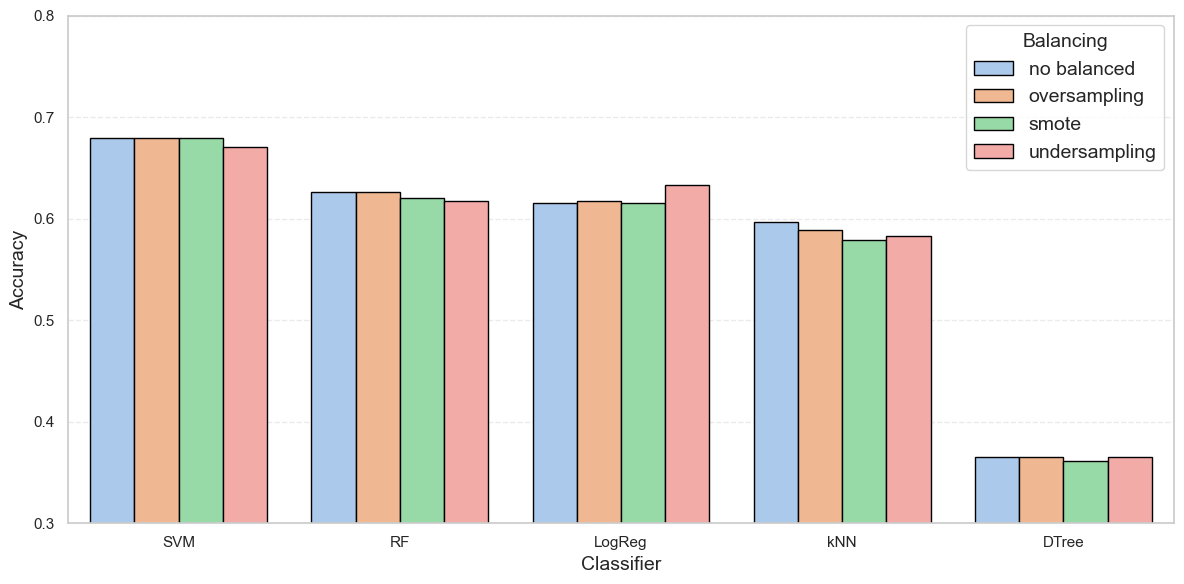

C:\Users\samue\AppData\Local\Temp\ipykernel_323924\1524964362.py:26: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(data=df, x="classifier", y="accuracy", hue="balancing", palette=palette, edgecolor="black")


no balanced: (0.6720588235294118, 0.789705882352941, 0.9161764705882354, 1)
oversampling: (0.9387254901960784, 0.7181372549019608, 0.571078431372549, 1)
smote: (0.5960784313725491, 0.8549019607843138, 0.6549019607843137, 1)
undersampling: (0.9509803921568627, 0.6686274509803923, 0.6568627450980393, 1)


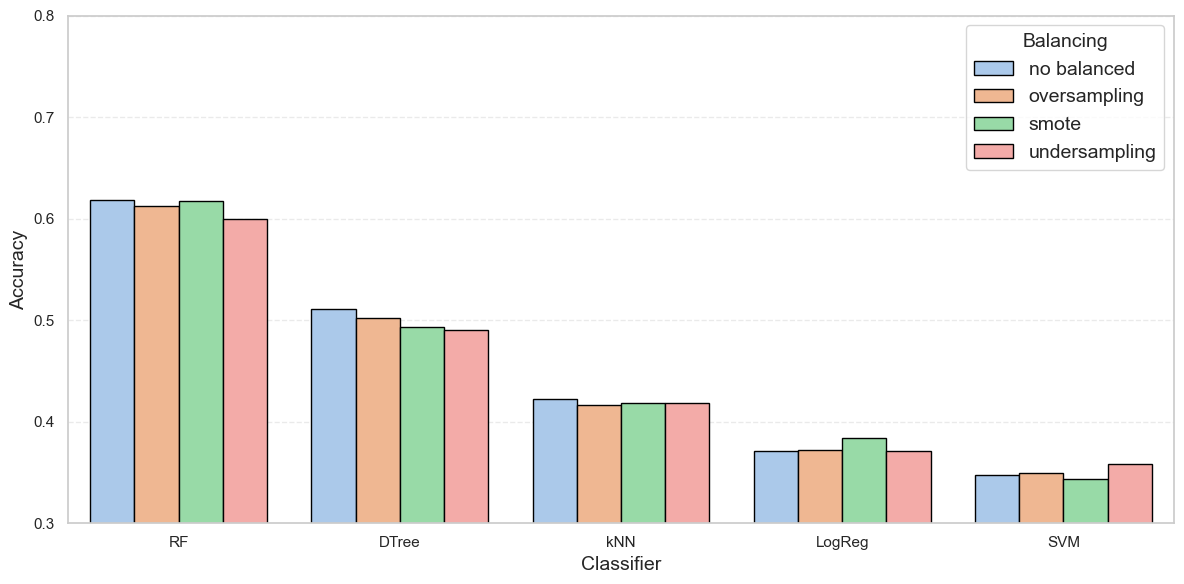

C:\Users\samue\AppData\Local\Temp\ipykernel_323924\1524964362.py:26: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(data=df, x="classifier", y="accuracy", hue="balancing", palette=palette, edgecolor="black")


no balanced: (0.6720588235294118, 0.789705882352941, 0.9161764705882354, 1)
oversampling: (0.9387254901960784, 0.7181372549019608, 0.571078431372549, 1)
smote: (0.5960784313725491, 0.8549019607843138, 0.6549019607843137, 1)
undersampling: (0.9509803921568627, 0.6686274509803923, 0.6568627450980393, 1)


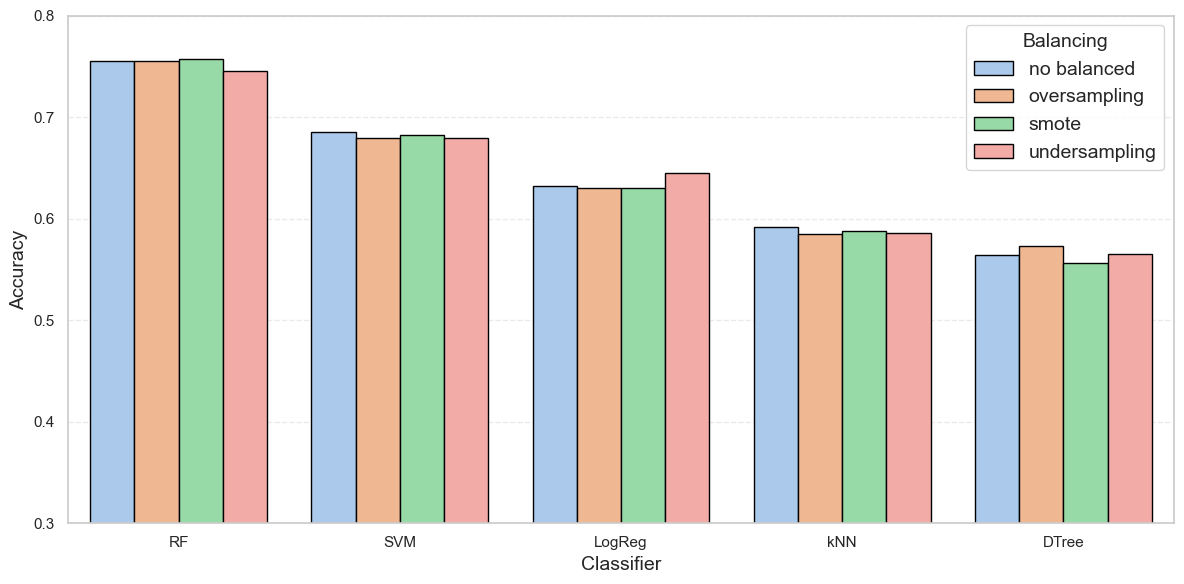

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

name = "only_emb"
#name = "only_extra"
#name = "emb_extra"
names=['only_extra', 'only_emb', 'emb_extra']

for name in names:
    path = "C:/Users/samue/Downloads/NFT25/final/"+name+"/results_"+name+"_table.csv"
    df = pd.read_csv(path)

    # Manter apenas as colunas de interesse
    df = df[['classifier', 'balancing', 'accuracy']]
    df = df.sort_values(by=['balancing', 'accuracy'], ascending=[True, False])

    # Set style for the plot
    sns.set(style="whitegrid")

    # Usar uma paleta de cores mais limpa e suave
    palette = sns.color_palette("pastel")

    # Criar o gráfico de barras para accuracy
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x="classifier", y="accuracy", hue="balancing", palette=palette, edgecolor="black")

    # Ajustes do gráfico
    plt.ylim(0.3, 0.8)
    plt.ylabel("Accuracy", fontsize=14)
    plt.xlabel("Classifier", fontsize=14)
    plt.legend(title="Balancing", fontsize=14, title_fontsize=14)

    # Exibir a grade no eixo Y
    plt.grid(True, axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
        
    # Salvar o gráfico como imagem PNG
    #plt.savefig('C:/Users/samue/Downloads/NFT25/final/Scenario1.png')

    # Mostrar o gráfico
    plt.show()


C:\Users\samue\AppData\Local\Temp\ipykernel_323924\3181172018.py:26: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(data=df, x="classifier", y="accuracy", hue="balancing", palette=palette, edgecolor="black", width=0.7)


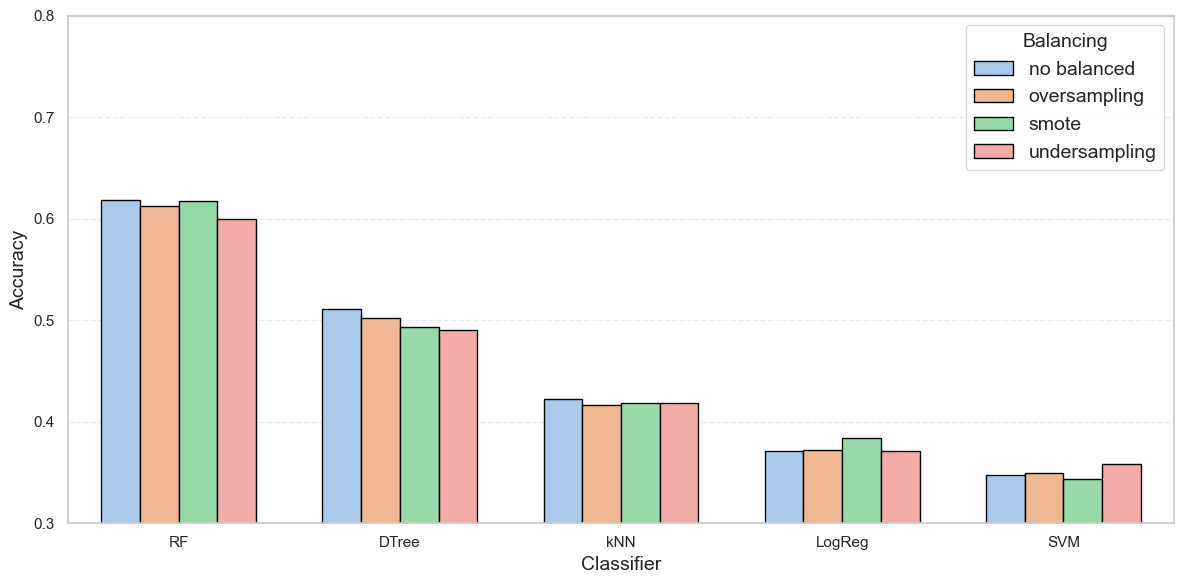

C:\Users\samue\AppData\Local\Temp\ipykernel_323924\3181172018.py:26: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(data=df, x="classifier", y="accuracy", hue="balancing", palette=palette, edgecolor="black", width=0.7)


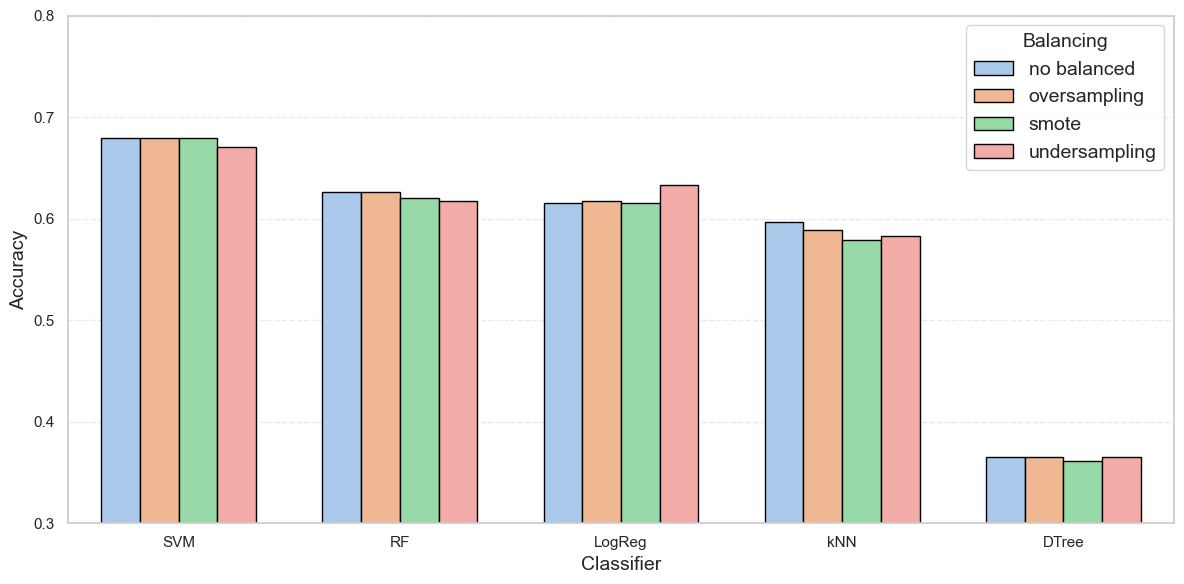

C:\Users\samue\AppData\Local\Temp\ipykernel_323924\3181172018.py:26: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(data=df, x="classifier", y="accuracy", hue="balancing", palette=palette, edgecolor="black", width=0.7)


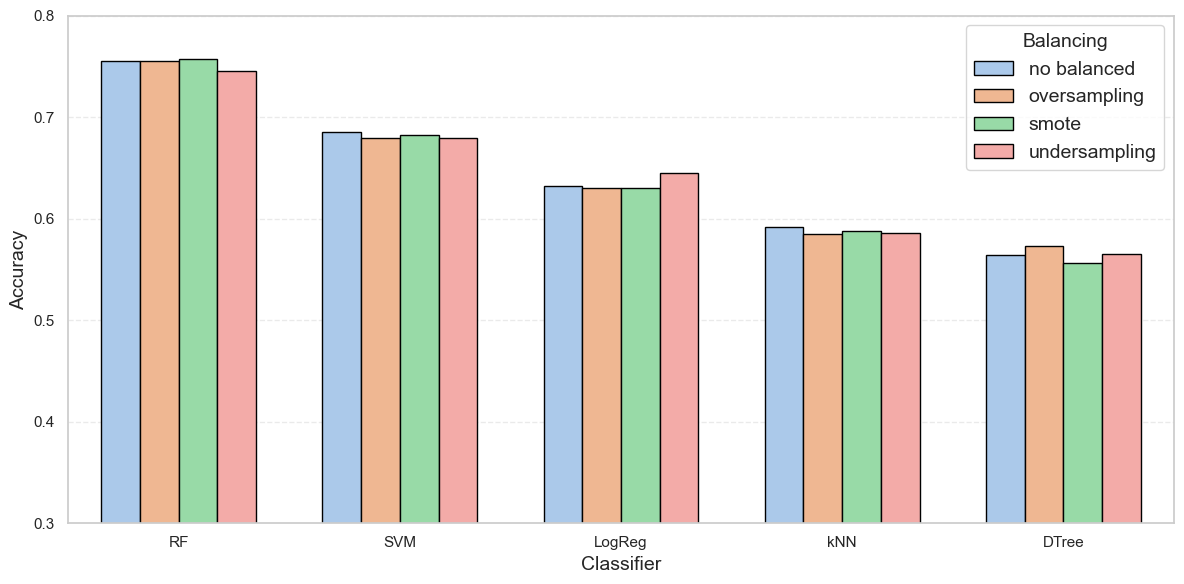

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

names = ['only_extra', 'only_emb', 'emb_extra']

for name in names:
    path = f"C:/Users/samue/Downloads/NFT25/final/{name}/results_{name}_table.csv"
    df = pd.read_csv(path)

    # Verificando se a coluna 'embedding' existe
    embedding_value = df['embedding'].iloc[0] if 'embedding' in df.columns else 'No Embedding'

    # Manter apenas as colunas de interesse
    df = df[['classifier', 'balancing', 'accuracy', 'embedding']]
    df = df.sort_values(by=['balancing', 'accuracy'], ascending=[True, False])

    # Set style for the plot
    sns.set(style="whitegrid")

    # Usar uma paleta de cores mais limpa e suave
    palette = sns.color_palette("pastel")

    # Criar o gráfico de barras para accuracy com uma largura ajustada
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=df, x="classifier", y="accuracy", hue="balancing", palette=palette, edgecolor="black", width=0.7)

    # Ajustes do gráfico
    plt.ylim(0.3, 0.8)
    plt.ylabel("Accuracy", fontsize=14)
    plt.xlabel("Classifier", fontsize=14)
    plt.legend(title="Balancing", fontsize=14, title_fontsize=14)

    # Verificar se é um dos casos onde o embedding precisa ser mostrado dentro das barras
    #if name in ['only_emb', 'emb_extra'] and 'embedding' in df.columns:
    #    for i, row in df.iterrows():
    #        # Adicionar o nome do embedding dentro da barra e centralizá-lo com ajuste de posição
    #        ax.text(-0.3+i/8, row['accuracy'], row['embedding'], ha='center', va='bottom', fontsize=10, color='black', rotation=90)

    plt.grid(True, axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()

    # Salvar o gráfico como imagem PNG
    plt.savefig(f'C:/Users/samue/Downloads/NFT25/final/{name}_scenario.pdf')

    # Mostrar o gráfico
    plt.show()


In [135]:
import pandas as pd

# Carregar o arquivo CSV
name = "only_emb"
#name = "only_extra"
#name = "emb_extra"
path = "C:/Users/samue/Downloads/NFT25/final/"+name+"/results_"+name+".csv"
path_save = "C:/Users/samue/Downloads/NFT25/final/"+name+"/results_"+name+"_table.csv"
if name == "only_extra":
    path = "C:/Users/samue/Downloads/NFT25/final/"+name+"/results_"+name+"_limpo.csv"
    


data = pd.read_csv(path, sep=';', header=0)
data = data[~data['classifier'].isin(['VotingSoft', 'VotingHard'])]

# Substituindo as vírgulas por ponto nas colunas numéricas
columns_to_convert = ['accuracy', 'precision', 'recall', 'f1', 
                      'auroc_art', 'auroc_gaming', 'auroc_memberships', 
                      'auroc_music', 'auroc_pfps', 'auroc_photography', 
                      'auroc_virtual-worlds']
data[columns_to_convert] = data[columns_to_convert].apply(lambda x: x.str.replace(',', '.')).apply(pd.to_numeric, errors='coerce')
data['auroc'] = data[['auroc_art', 'auroc_gaming', 'auroc_memberships', 
                       'auroc_music', 'auroc_pfps', 'auroc_photography', 
                       'auroc_virtual-worlds']].mean(axis=1)

data_filtered = data[~data['classifier'].isin(['voting soft', 'voting hard'])]

data_filtered = data_filtered[['balancing','classifier', 'embedding', 'accuracy', 'precision', 
                                'recall', 'f1', 'auroc']]

if name != "only_extra":
    # Substituindo apenas a parte correspondente da string na coluna 'embedding'
    data_filtered['embedding'] = data_filtered['embedding'].str.replace(
        'paraphrase-multilingual-MiniLM-L12-v2', 'M2', regex=False).str.replace(
        'all-MiniLM-L6-v2', 'M1', regex=False)

# Agrupar os dados por 'classifier' e 'balancing', e ordenar por 'accuracy' e 'f1' (em caso de empate)
data_sorted = data_filtered.sort_values(by=['balancing', 'classifier', 'accuracy', 'f1'], ascending=[True, True, False, False])

# Manter apenas o primeiro valor de 'embedding' para cada combinação de 'classifier' e 'balancing'
data_final = data_sorted.groupby(['balancing', 'classifier']).first().reset_index()

# Trocar a ordem das colunas: 'balancing' e 'classifier'
#data_final = data_final[['balancing','classifier', 'embedding', 'accuracy', 'precision', 'recall', 'f1', 'auroc']]

# Verificando o resultado
data_final.to_csv(path_save, index=False)


In [136]:
data_final

,balancing,classifier,embedding,accuracy,precision,recall,f1,auroc
0,no balanced,DTree,clean_lemmatization_M2,0.365243,0.366503,0.365978,0.364482,0.633445
1,no balanced,LogReg,clean_stopwords_M1,0.615611,0.623057,0.616901,0.619418,0.879813
2,no balanced,RF,lemmatization_M2,0.625920,0.632738,0.627514,0.628077,0.872619
3,no balanced,SVM,stopwords_lemmatization_M1,0.678940,0.697924,0.678954,0.684713,0.911187
4,no balanced,kNN,clean_stopwords_M1,0.596465,0.620991,0.597395,0.600414,0.845712
5,oversampling,DTree,clean_stopwords_lemmatization_M2,0.365243,0.368735,0.366587,0.366850,0.629727
6,oversampling,LogReg,clean_stopwords_M1,0.617084,0.625071,0.618471,0.621168,0.879695
7,oversampling,RF,clean_M2,0.625920,0.636875,0.627893,0.630101,0.874288
8,oversampling,SVM,stopwords_lemmatization_M1,0.678940,0.695714,0.679114,0.684222,0.910767
9,oversampling,kNN,clean_stopwords_M1,0.589102,0.610395,0.590493,0.592244,0.843155
